## XieZhenghang 一号策略

    策略思路：设定唐安奇通道上线，为50分钟收盘最大值，当分钟的最大值突破上一分钟通道的上线1.01倍时认为有上涨趋势并做多，分钟最小值突破上线0.99倍且上一分钟是在上线之上时判断有下跌趋势并做空（若有仓位，突破时平仓，并且反向开仓）。

    退出条件：15%止损，30%止盈

    策略结果：全年sharpe 2.14，最大回撤-0.79%，但存在三笔异常亏损（2017年11月12日至2017年12月11日三笔亏损，形成最大回撤，期间比特币暴涨却却触发本策略卖空动作。) 半年Sharpe2.7,最大回撤-0.3%，稳健上升。

    缺点：止损位置高，不能加大杠杆，并且在趋势行情中出现了较大回撤。



In [5]:
from vnpy.trader.app.ctaStrategy.ctaBacktesting import BacktestingEngine, OptimizationSetting, MINUTE_DB_NAME

# 创建回测引擎对象
engine = BacktestingEngine()
# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase(MINUTE_DB_NAME)  # 设置使用的历史数据库
engine.setStartDate('20170703',initDays=1)               # 设置回测用的数据起始日期
engine.setEndDate('20180630')
# 配置回测引擎参数
engine.setSlippage(0.1)     # 设置滑点为股指1跳
engine.setRate(1/1000)   # 设置手续费千1
engine.setSize(1)         # 设置合约大小 
engine.setPriceTick(0.1)    # 设置股指最小价格变动   
engine.setCapital(1000000)  # 设置回测本金

In [6]:

from __future__ import division

from vnpy.trader.vtConstant import EMPTY_STRING, EMPTY_FLOAT
from vnpy.trader.app.ctaStrategy.ctaTemplate import (CtaTemplate, 
                                                     BarGenerator,
                                                     ArrayManager)
import talib as ta
########################################################################
# 策略继承CtaTemplate
class SuiBianXieDe(CtaTemplate):
    className = 'SuiBianXieDe'
    author = 'ZhenghangXie'
    
    # 策略交易标的的列表
    symbolList = []         # 初始化为空
    posDict = {}  # 初始化仓位字典
    
    # 多空仓位
    Longpos = EMPTY_STRING        # 多头品种仓位
    Shortpos = EMPTY_STRING       # 空头品种仓位

    ##########   
    # 策略参数
    LongWindow = 55     # 长期窗口
    ShortWindow = 20     # 短期窗口
    initDays = 1       # 初始化数据所用的天数  
    stopRatio = 0.15   # 止损比例


    # 策略变量
    LongMax = EMPTY_FLOAT  # 长期最高价位
    ShortMax = EMPTY_FLOAT   # 长期最高价位
    LongMin = EMPTY_FLOAT  # 长期最高价位
    ShortMin = EMPTY_FLOAT   # 长期最高价位
    transactionPrice = EMPTY_FLOAT # 记录成交价格
    
    ##########
    
        # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'vtSymbol',
                 'symbolList',
                'LongWindow',
                'ShortWindow',
                'stopRatio']    
    
    # 变量列表，保存了变量的名称
    varList = ['inited',
               'trading',
               'posDict',
               'LongMax',
               'ShortMax',
               'LongMin',
               'ShortMin',
              'LongAve',
              'ShortAve',
              'transactionPrice',
              'maTrend']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict']
    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super(SuiBianXieDe, self).__init__(ctaEngine, setting)
        
        # 给多空仓位命名
        symbol = self.symbolList[0]
        self.Longpos = symbol.replace('.','_')+"_LONG"
        self.Shortpos = symbol.replace('.','_')+"_SHORT"
        
            
        self.amDict = {
            sym: ArrayManager(size=100)
            for sym in self.symbolList
        }
        
        
        

      
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.writeCtaLog(u'海龟策略初始化')
        # 初始化仓位字典
        self.ctaEngine.initPosition(self)
#         if not self.posDict:
#             for symbolPos in [self.Longpos,self.Shortpos]:
#                 self.posDict[symbolPos] = 0
        # 初始化历史数据天数
        initData = self.loadBar(self.initDays)
        for bar in initData:
            self.onBar(bar)
        
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'海龟策略初始化')
        #print('start',file=test)
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.writeCtaLog(u'海龟策略初始化')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        pass

    
        
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        self.cancelAll() # 全部撤单
        symbol = bar.vtSymbol
        
        
        
        # 洗价器（止损止盈）
        if (self.posDict[self.Longpos] > 0):
            if (bar.close<self.transactionPrice*(1-self.stopRatio)) or (bar.close>self.transactionPrice*(1+2*self.stopRatio)):
                self.cancelAll()
                self.sell(symbol,bar.close, 1)
        elif (self.posDict[self.Shortpos] > 0):
            if (bar.close>self.transactionPrice*(1+self.stopRatio)) or  (bar.close<self.transactionPrice*(1-2*self.stopRatio)):
                self.cancelAll()
                self.cover(symbol,bar.close, 1)
                
        self.amDict[symbol].updateBar(bar)
        am = self.amDict[symbol]
        if not am.inited:
            return
        
        
        ######### 计算策略需要的信号-------------------------------------------------####################################            
        Shortmax = ta.MAX(am.high,timeperiod=50)        
        Shortmin = ta.MIN(am.low,timeperiod=50)
        self.amclose0 = am.close[-1]
        self.amclose1 = am.close[-2]
        self.smax0 = Shortmax[-2]
        self.smax1 = Shortmax[-3]
        self.smin0 = Shortmax[-2]
        self.smin1 = Shortmax[-3]
        
        

        if self.amclose0 >= 1.01*self.smax0 and  self.amclose1 < self.smax1:
            self.Cross = 1
        elif self.amclose0 <= 0.99*self.smin0 and  self.amclose1 > self.smin1:
            self.Cross = -1 
        else:
            self.Cross = 0
        
        self.signal = self.Cross 
        
        
        if self.signal >=1:
            # 如果无持仓，突破短期上限则直接做多
            if (self.posDict[self.Longpos]==0) and (self.posDict[self.Shortpos]==0):
                #print('signal',self.signal,file = test)
                #print('time:%s,amclose0:%s, amclose1:%s, smax0:%s, smax1:%s'%(bar.datetime,self.amclose0,self.amclose1,self.smax0,self.smax1),file=test)
                self.buy(symbol,bar.close, 1)                
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[self.Shortpos] == 1:
                self.cover(symbol,bar.close, 1)
                self.buy(symbol,bar.close, 1)
                #print('signal',self.signal,file = test)
                #print('time:%s,amclose0:%s, amclose1:%s, smax0:%s, smax1:%s'%(bar.datetime,self.amclose0,self.amclose1,self.smax0,self.smax1),file=test)
        # 突破下线则相反，多头持仓先卖掉多头再卖空
        elif self.signal <=-1:
            if (self.posDict[self.Longpos]==0) and (self.posDict[self.Shortpos]==0):
                #print('signal',self.signal,file = test)
                #print('time:%s,amclose0:%s, amclose1:%s, smin0:%s, smin1:%s'%(bar.datetime,self.amclose0,self.amclose1,self.smin0,self.smin1),file=test)
                self.short(symbol,bar.close,1)
            elif self.posDict[self.Longpos] == 1:
                self.sell(symbol,bar.close, 1)
                self.short(symbol,bar.close,1)
                #print('signal',self.signal,file = test)
                #print('time:%s,amclose0:%s, amclose1:%s, smin0:%s, smin1:%s'%(bar.datetime,self.amclose0,self.amclose1,self.smin0,self.smin1),file=test)

        # 发出状态更新事件
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        self.transactionPrice = trade.price
#         print('price:%s, direction:%s, offset:%s,amclose0:%s,amclose1:%s,max0:%s,max1:%s,min0:%s,min1:%s'
#                 %(trade.price, trade.direction, trade.offset,self.amclose0,self.amclose1,self.smax0,self.smax1,self.smin0,self.smin1),file=test)
        pass
    
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [7]:
# 在引擎中创建策略对象
test = open('test.txt','w')
d = {'ShortWindow': 20 , 'symbolList':['tBTCUSD:bitfinex']}                    # 策略参数配置
engine.initStrategy(SuiBianXieDe, d)    # 创建策略对象
engine.runBacktesting()
test.close()

2018-09-06 16:18:38.284797	开始回测
2018-09-06 16:18:38.286797	策略初始化
2018-09-06 16:18:38.288798	载入历史数据。数据范围:[20170702,20170703)
2018-09-06 16:18:38.464808	载入完成，数据量：1409
2018-09-06 16:18:38.489809	策略初始化完成
2018-09-06 16:18:38.489809	策略启动完成
2018-09-06 16:18:38.489809	开始回放回测数据,回测范围:[20170703,20180701)
2018-09-06 16:18:38.492809	载入历史数据。数据范围:[20170703,20180701)
2018-09-06 16:20:17.106450	载入完成，数据量：521407
2018-09-06 16:20:17.693483	当前回放数据:[20170703,20180701)
2018-09-06 16:21:19.416014	数据回放结束ss: 100%    


In [8]:
# 显示前10条成交记录
for i in range(30):
    d = engine.tradeDict[str(i+1)].__dict__
    print('TradeID: %s, Time: %s, Direction: %s, Price: %s, Volume: %s' %(d['tradeID'], d['dt'], d['direction'], d['price'], d['volume']))

TradeID: 1, Time: 2017-08-05 16:25:00, Direction: 多, Price: 3200.0, Volume: 1
TradeID: 2, Time: 2017-08-13 16:04:00, Direction: 空, Price: 4176.7, Volume: 1
TradeID: 3, Time: 2017-08-19 20:47:00, Direction: 多, Price: 4150.0, Volume: 1
TradeID: 4, Time: 2017-09-14 20:57:00, Direction: 空, Price: 3514.2000000000003, Volume: 1
TradeID: 5, Time: 2017-09-15 20:24:00, Direction: 空, Price: 3235.0, Volume: 1
TradeID: 6, Time: 2017-09-15 20:39:00, Direction: 多, Price: 3310.4, Volume: 1
TradeID: 7, Time: 2017-09-15 20:39:00, Direction: 多, Price: 3310.4, Volume: 1
TradeID: 8, Time: 2017-09-30 15:56:00, Direction: 空, Price: 4311.7, Volume: 1
TradeID: 9, Time: 2017-10-08 06:57:00, Direction: 空, Price: 4438.400000000001, Volume: 1
TradeID: 10, Time: 2017-10-12 16:03:00, Direction: 多, Price: 5104.2, Volume: 1
TradeID: 11, Time: 2017-10-29 23:42:00, Direction: 空, Price: 5920.400000000001, Volume: 1
TradeID: 12, Time: 2017-11-02 08:55:00, Direction: 多, Price: 6809.9, Volume: 1
TradeID: 13, Time: 2017-11-

2018-09-06 16:21:29.743604	计算按日统计结果
2018-09-06 16:21:54.068996	------------------------------
2018-09-06 16:21:54.078996	首个交易日：	2017-07-03
2018-09-06 16:21:54.079996	最后交易日：	2018-06-30
2018-09-06 16:21:54.079996	总交易日：	363
2018-09-06 16:21:54.079996	盈利交易日	135
2018-09-06 16:21:54.079996	亏损交易日：	114
2018-09-06 16:21:54.080996	起始资金：	1000000
2018-09-06 16:21:54.106998	结束资金：	1,025,476.63
2018-09-06 16:21:54.107998	总收益率：	2.55%
2018-09-06 16:21:54.107998	年化收益：	1.68%
2018-09-06 16:21:54.107998	总盈亏：	25,476.63
2018-09-06 16:21:54.108998	最大回撤: 	-7,908.79
2018-09-06 16:21:54.109998	百分比最大回撤: -0.79%
2018-09-06 16:21:54.109998	总手续费：	800.46
2018-09-06 16:21:54.109998	总滑点：	8.3
2018-09-06 16:21:54.109998	总成交金额：	800,460.71
2018-09-06 16:21:54.110998	总成交笔数：	83
2018-09-06 16:21:54.110998	日均盈亏：	70.18
2018-09-06 16:21:54.110998	日均手续费：	2.21
2018-09-06 16:21:54.111998	日均滑点：	0.02
2018-09-06 16:21:54.111998	日均成交金额：	2,205.13
2018-09-06 16:21:54.111998	日均成交笔数：	0.23
2018-09-06 16:21:54.111998	日均收益率：	0.01%
2018-09-06 1

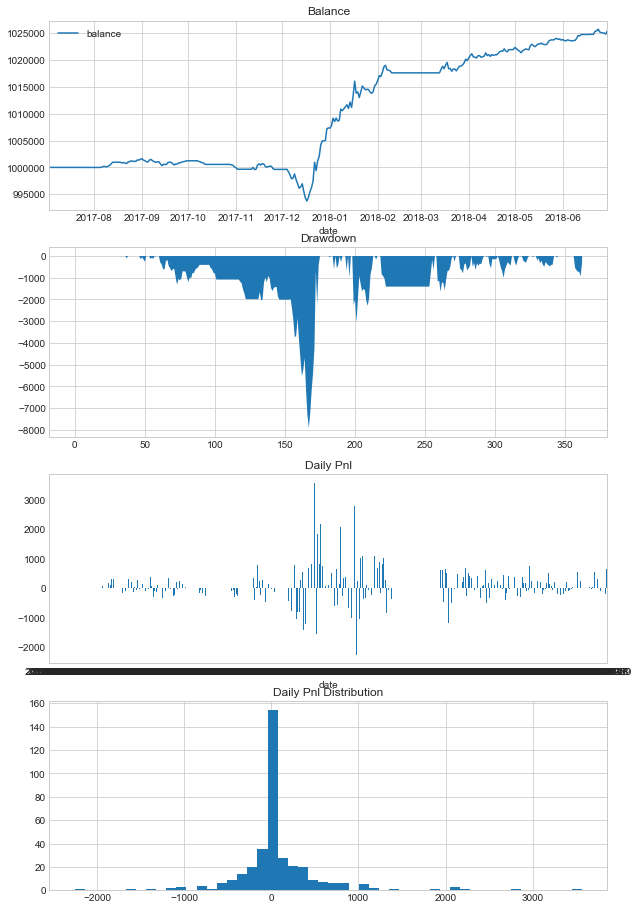

2018-09-06 16:22:32.772209	计算回测结果
2018-09-06 16:22:32.887216	------------------------------
2018-09-06 16:22:32.888216	第一笔交易：	2017-08-13 16:04:00
2018-09-06 16:22:32.888216	最后一笔交易：	2018-06-30 23:59:00
2018-09-06 16:22:32.888216	总交易次数：	42
2018-09-06 16:22:32.888216	总盈亏：	25,470.15
2018-09-06 16:22:32.888216	最大回撤: 	-5,592.42
2018-09-06 16:22:32.889216	平均每笔盈利：	606.43
2018-09-06 16:22:32.889216	平均每笔滑点：	0.2
2018-09-06 16:22:32.889216	平均每笔佣金：	19.21
2018-09-06 16:22:32.889216	胜率		59.52%
2018-09-06 16:22:32.890216	盈利交易平均值	1,535.09
2018-09-06 16:22:32.890216	亏损交易平均值	-759.24
2018-09-06 16:22:32.890216	盈亏比：	2.02


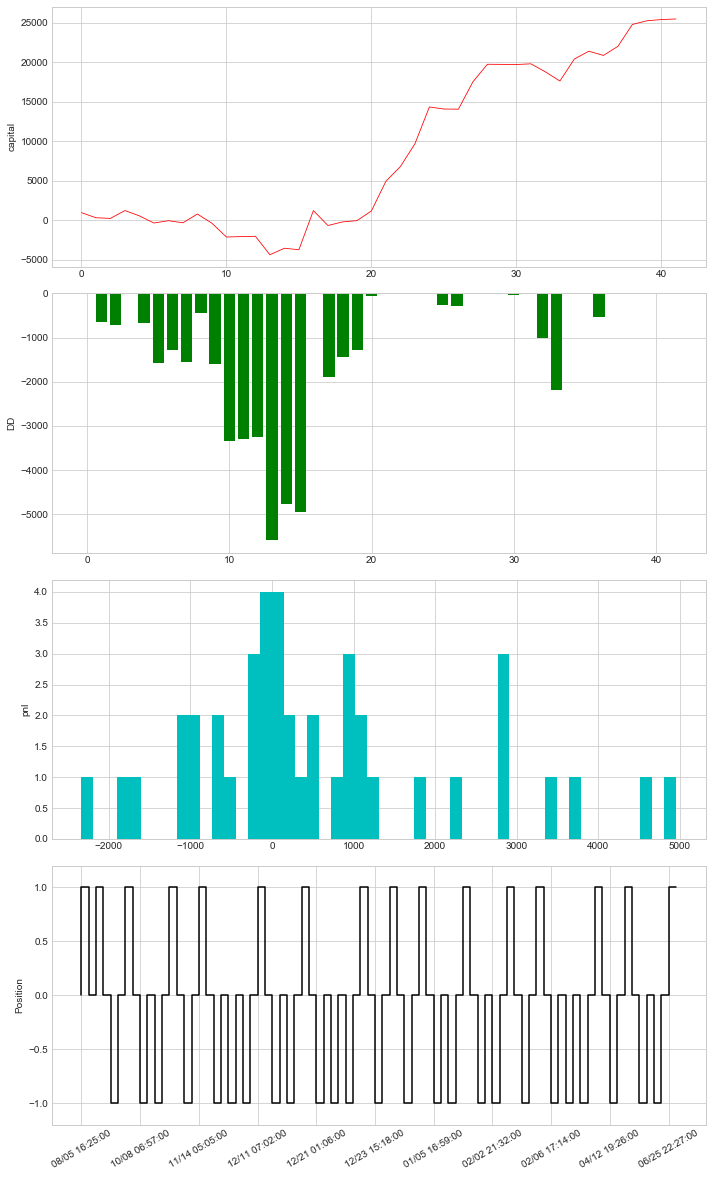

In [9]:
# 显示逐日回测结果
engine.showDailyResult()
# 显示逐笔回测结果
engine.showBacktestingResult()

2018-08-15 11:44:55.220699	计算按日统计结果
2018-08-15 11:44:55.268702	------------------------------
2018-08-15 11:44:55.269702	首个交易日：	2018-01-01
2018-08-15 11:44:55.269702	最后交易日：	2018-06-30
2018-08-15 11:44:55.269702	总交易日：	181
2018-08-15 11:44:55.269702	盈利交易日	79
2018-08-15 11:44:55.269702	亏损交易日：	62
2018-08-15 11:44:55.269702	起始资金：	1000000
2018-08-15 11:44:55.269702	结束资金：	1,015,813.09
2018-08-15 11:44:55.269702	总收益率：	1.58%
2018-08-15 11:44:55.269702	年化收益：	2.1%
2018-08-15 11:44:55.269702	总盈亏：	15,813.09
2018-08-15 11:44:55.269702	最大回撤: 	-3,054.4
2018-08-15 11:44:55.269702	百分比最大回撤: -0.3%
2018-08-15 11:44:55.269702	总手续费：	318.1
2018-08-15 11:44:55.269702	总滑点：	3.7
2018-08-15 11:44:55.269702	总成交金额：	318,099.21
2018-08-15 11:44:55.269702	总成交笔数：	37
2018-08-15 11:44:55.269702	日均盈亏：	87.37
2018-08-15 11:44:55.269702	日均手续费：	1.76
2018-08-15 11:44:55.270702	日均滑点：	0.02
2018-08-15 11:44:55.270702	日均成交金额：	1,757.45
2018-08-15 11:44:55.270702	日均成交笔数：	0.2
2018-08-15 11:44:55.270702	日均收益率：	0.01%
2018-08-15 11:44:55

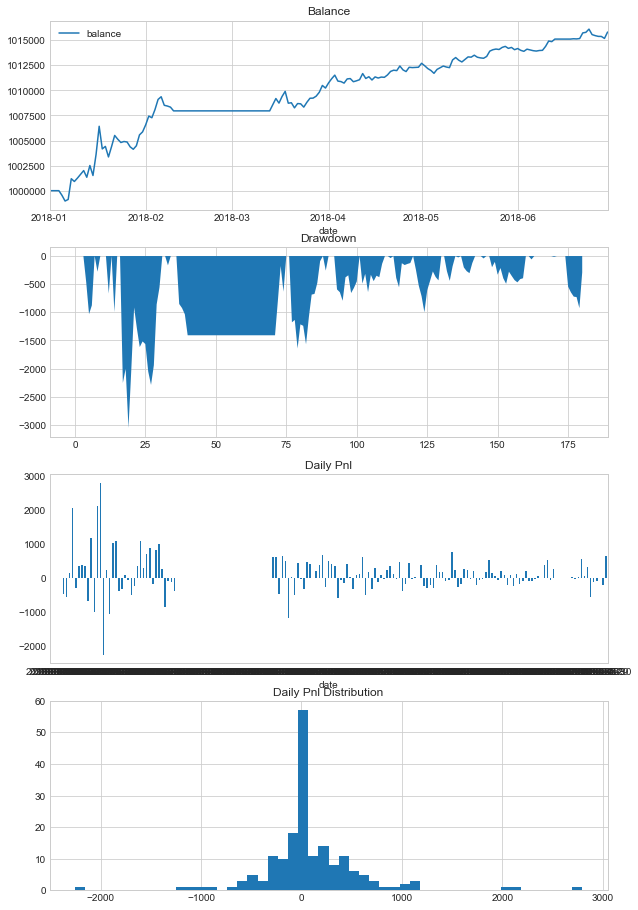

2018-08-15 11:44:57.305819	计算回测结果
2018-08-15 11:44:57.307819	------------------------------
2018-08-15 11:44:57.308819	第一笔交易：	2018-01-05 16:59:00
2018-08-15 11:44:57.308819	最后一笔交易：	2018-06-30 23:59:00
2018-08-15 11:44:57.308819	总交易次数：	19
2018-08-15 11:44:57.308819	总盈亏：	15,806.61
2018-08-15 11:44:57.308819	最大回撤: 	-2,178.31
2018-08-15 11:44:57.308819	平均每笔盈利：	831.93
2018-08-15 11:44:57.308819	平均每笔滑点：	0.2
2018-08-15 11:44:57.308819	平均每笔佣金：	17.08
2018-08-15 11:44:57.308819	胜率		63.16%
2018-08-15 11:44:57.308819	盈利交易平均值	1,569.17
2018-08-15 11:44:57.308819	亏损交易平均值	-431.92
2018-08-15 11:44:57.308819	盈亏比：	3.63


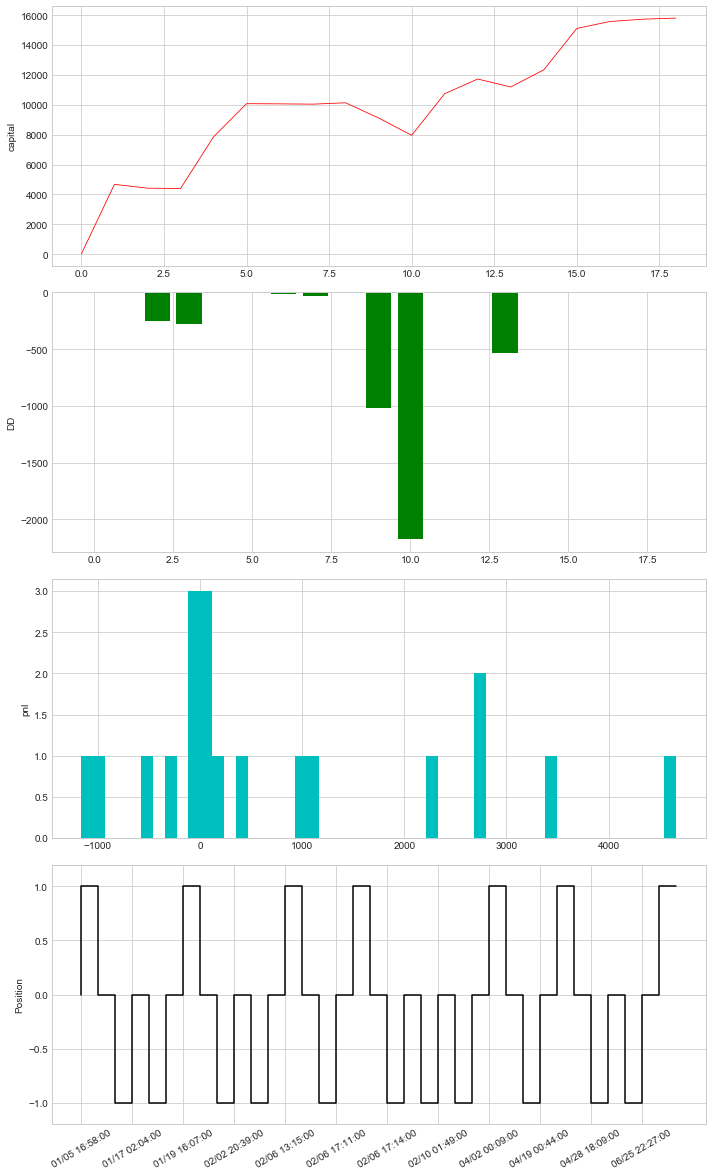

In [161]:
# 显示逐日回测结果
engine.showDailyResult()
# 显示逐笔回测结果
engine.showBacktestingResult()